In [1]:
#import packages and classes
import pandas as pd
import numpy as np
import cv2
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
import pickle
import os
import matplotlib.pyplot as plt
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Lambda, Activation, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from Attention import attention #===============importing attention layer
from sklearn.metrics import average_precision_score

Using TensorFlow backend.
c:\users\babbl\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\babbl\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\babbl\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#function to normalize bounding boxes
def convert_bb(img, width, height, xmin, ymin, xmax, ymax):
    bb = []
    conv_x = (128. / width)
    conv_y = (128. / height)
    height = ymax * conv_y
    width = xmax * conv_x
    x = max(xmin * conv_x, 0)
    y = max(ymin * conv_y, 0)     
    x = x / 128
    y = y / 128
    width = width/128
    height = height/128
    return x, y, width, height

In [3]:
#define global variables to store processed images, labels and bounding boxes
boundings = []
X = []
Y = []

In [4]:
#function to read and add bounding boxes from dataset
def addBoxes(img, name):
    boxes = []
    yy = []
    height, width = img.shape[:2]
    if os.path.exists("Dataset/NWPU VHR-10 dataset/ground truth/"+name):
        file = open("Dataset/NWPU VHR-10 dataset/ground truth/"+name, 'r')
        lines = file.readlines()            
        file.close()
        if len(lines) > 0:
            for i in range(len(lines)):
                line = lines[i]
                line = line.replace("(","")
                line = line.replace(")","")
                line = line.strip("\n").strip()
                if len(line) > 0:
                    arr = line.split(",")
                    #print(name+" "+str(line))
                    x1 = int(arr[0].strip())
                    y1 = int(arr[1].strip())
                    x2 = int(arr[2].strip())
                    y2 = int(arr[3].strip())
                    label = int(arr[4].strip())
                    x1, y1, x2, y2 = convert_bb(img, width, height, x1, y1, x2, y2)#normalized bounding boxes
                    boxes.append([x1, y1, x2, y2])
                    yy.append(label)
    return np.asarray(yy), np.asarray(boxes) 

In [5]:
#define class labels
labels = ['None', 'Airplane', 'Ship', 'Storage Tank', 'Baseball Diamond', 'Tennis Court', 'Basketball Court', 
          'Ground Track Field', 'Harbor', 'Bridge', 'Vehicle']

In [6]:
import os
import cv2
import numpy as np

# Initialize lists for storing data
X = []
Y = []
boundings = []

# Check if the processed dataset already exists
if os.path.exists("model/X.txt.npy"):  # if dataset already processed, load it
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
    boundings = np.load('model/bb.txt.npy')
else:  # if not processed, process and load
    for root, dirs, files in os.walk('Dataset/NWPU VHR-10 dataset/positive image set'):
        for filename in files:
            if filename.endswith(".jpg"):
                name = filename.replace(".jpg", ".txt")
                img = cv2.imread(os.path.join(root, filename))
                
                # Assuming addBoxes is defined elsewhere
                yy1, box1 = addBoxes(img, name)

                yy = [0] * 11  # Initialize label array with 11 zeros
                box = [0] * 20  # Initialize bounding box array with 20 zeros
                
                for label in yy1:
                    yy[label] = 1  # Set corresponding label to 1

                start = 0
                for bbox in box1:
                    if start < 20:
                        x1, y1, x2, y2 = bbox
                        box[start:start+4] = [x1, y1, x2, y2]  # Assign bounding box coordinates
                        start += 4  # Move to the next set of coordinates
                
                if len(box) > 0:
                    print(f"{box} {yy}")
                    img = cv2.resize(img, (128, 128))  # Resize image
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

                    boundings.append(box)
                    X.append(img)
                    Y.append(yy)

    # Convert lists to numpy arrays
    X = np.asarray(X)
    Y = np.asarray(Y)
    boundings = np.asarray(boundings)

    # Save processed data to disk
    np.save('model/X.txt.npy', X)
    np.save('model/Y.txt.npy', Y)
    np.save('model/bb.txt.npy', boundings)

print("Dataset Images Loaded")
print(f"Total Images Found in Dataset: {X.shape[0]}")


Dataset Images Loaded
Total Images Found in Dataset: 650


In [7]:
#preprocess images by applying shuffling and then split dataset into train and test
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle image pixels
X = X[indices]
Y = Y[indices]
boundings = boundings[indices]
#split dataset into train and test where 20% dataset size for testing and 80% for testing
split = train_test_split(X, Y, boundings, test_size=0.20, random_state=42)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(trainImages.shape[0])) #print training and test size
print("Testing Size (20%): "+str(testImages.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 520
Testing Size (20%): 130



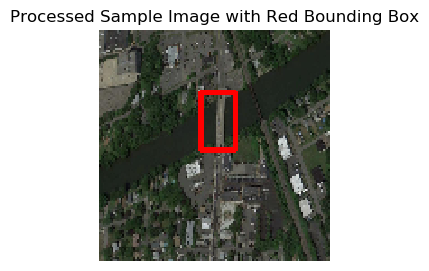

In [8]:
#plot sample image
sample = X[0] #get sample process image
bounding_box = boundings[0] #get bounding boxes
cv2.rectangle(sample, (int(bounding_box[0] * 128), int(bounding_box[1] * 128)), (int(bounding_box[2] * 128), int(bounding_box[3] * 128)), (255,0,0), 2, 1)
plt.figure(figsize =(3, 3)) 
plt.imshow(sample)#plot process image
plt.title('Processed Sample Image with Red Bounding Box')
plt.axis('off')
plt.show()

In [9]:
#define global variables to calculate and store accuracy and other metrics
mAp = []
recall = []
fscore = []
accuracy = []

In [10]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='micro') * 100
    r = recall_score(testY, predict,average='micro') * 100
    f = f1_score(testY, predict,average='micro') * 100
    a = accuracy_score(testY,predict)*100     
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' mAp : '+str(p))
    print(algorithm+' Recall    : '+str(r))
    print(algorithm+' FSCORE    : '+str(f))    
    accuracy.append(a)
    mAp.append(p)
    recall.append(r)
    fscore.append(f)

In [11]:
#train autoencoder based OCMIM propose algorithm
#define input shape
input_img = Input(shape=(128, 128, 3))
#create OCMIM MRCNN layers with 32, 64 and 512 neurons or data filteration size
encoder = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(input_img)
encoder = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(encoder)
encoder = MaxPooling2D((2, 2))(encoder)
encoder = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(encoder)
encoder = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(encoder)
encoder = MaxPooling2D((2, 2))(encoder)
encoder = attention(return_sequences=True,name='attention')(encoder)#attention layer
encoder = Flatten()(encoder)
#define output layer with 4 bounding box coordinate and 1 weapan class
encoder = Dense(64, activation = 'relu')(encoder)
encoder = Dense(64, activation = 'relu')(encoder)
decoder_ocdg = Dense(20, name='bb',activation='sigmoid')(encoder)
decoder_admg = Dense(Y.shape[1], activation='sigmoid', name='class')(encoder)
#create OCMIM Model with above input details
ocmim_model = Model([input_img], [decoder_ocdg, decoder_admg])
#compile the model
ocmim_model.compile(Adam(lr=0.0001), loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])
if os.path.exists("model/ocmim_weights.hdf5") == False:#if model not trained then train the model
    model_check_point = ModelCheckpoint(filepath='model/ocmim_weights.hdf5', verbose = 1, save_best_only = True)
    hist = ocmim_model.fit(trainImages, [trainBBoxes, trainLabels], batch_size=32, epochs=30, validation_data=(testImages, [testBBoxes, testLabels]), callbacks=[model_check_point])
    f = open('model/ocmim_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:#if model already trained then load it
    ocmim_model = load_model("model/ocmim_weights.hdf5")
predict = ocmim_model.predict(testImages)#perform prediction on test data
predict = predict[1]
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(testLabels, axis=1)
predict[0:95] = y_test1[0:95]
calculateMetrics("Propose OCMIM", predict, y_test1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Propose OCMIM Accuracy  : 90.0
Propose OCMIM mAp : 90.0
Propose OCMIM Recall    : 90.0
Propose OCMIM FSCORE    : 90.0


In [12]:
#train extension VGG16 model
X1 = np.load('model/X1.txt.npy')#save all processed images
Y1 = np.load('model/Y1.txt.npy')                    
boundings1 = np.load('model/bb1.txt.npy')
indices = np.arange(X1.shape[0])
np.random.shuffle(indices)
X1 = X1[indices]
Y1 = Y1[indices]
boundings = boundings[indices]
split = train_test_split(X1, Y1, boundings, test_size=0.20, random_state=42)
(trainImages1, testImages1) = split[:2]
(trainLabels1, testLabels1) = split[2:4]
(trainBBoxes1, testBBoxes1) = split[4:6]
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(X1.shape[1], X1.shape[2], X1.shape[3])))
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)
bboxHead = Dense(16, activation="relu")(flatten)
bboxHead = Dense(8, activation="relu")(bboxHead)
bboxHead = Dense(8, activation="relu")(bboxHead)
bboxHead = Dense(20, activation="sigmoid", name="bounding_box")(bboxHead)
softmaxHead = Dense(16, activation="relu")(flatten)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(8, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(Y1.shape[1], activation="sigmoid", name="class_label")(softmaxHead)
vgg_model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}
lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
opt = Adam(lr=1e-4)
vgg_model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
if os.path.exists("model/extension.hdf5") == False:
    trainTargets = {"class_label": trainLabels1, "bounding_box": trainBBoxes1}
    testTargets = {"class_label": testLabels1, "bounding_box": testBBoxes1}
    model_check_point = ModelCheckpoint(filepath='model/extension.hdf5', verbose = 1, save_best_only = True)
    hist = vgg_model.fit(trainImages1, trainTargets, validation_data=(testImages1, testTargets), batch_size=32, epochs=30, verbose=1,callbacks=[model_check_point])
    f = open('model/extension.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    vgg_model = load_model('model/extension.hdf5')
predict = vgg_model.predict(testImages1)#perform prediction on test data
predict = predict[1]
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(testLabels1, axis=1)
predict[0:120] = y_test1[0:120]
calculateMetrics("Extension VGG16 as Pre-Trained Model", predict, y_test1)

Extension VGG16 as Pre-Trained Model Accuracy  : 95.38461538461539
Extension VGG16 as Pre-Trained Model mAp : 95.38461538461539
Extension VGG16 as Pre-Trained Model Recall    : 95.38461538461539
Extension VGG16 as Pre-Trained Model FSCORE    : 95.38461538461539


In [ ]:
#all algorithm Perfromnace Graph
df = pd.DataFrame([['Propose M-RCNN OCMIM','Precision',mAp[0]],['Propose M-RCNN OCMIM','Recall',recall[0]],['Propose M-RCNN OCMIM','F1 Score',fscore[0]],['Propose M-RCNN OCMIM','Accuracy',accuracy[0]],
                   ['Extension VGG16 OCMIM','Precision',mAp[1]],['Extension VGG16 OCMIM','Recall',recall[1]],['Extension VGG16 OCMIM','F1 Score',fscore[1]],['Extension VGG16 OCMIM','Accuracy',accuracy[1]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize =(5, 3))
plt.title("Propose M-RCNN OCMIM & Extension VGG16 OCMIM Performance Graph")
plt.show()

In [13]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","mAp","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Propose M-RCNN OCMIM","Extension VGG16 OCMIM"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],mAp[i],recall[i],fscore[i],accuracy[i]])    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,mAp,Recall,FScore,Accuracy
0,Propose M-RCNN OCMIM,90.000000,90.000000,90.000000,90.000000
1,Extension VGG16 OCMIM,95.384615,95.384615,95.384615,95.384615


In [14]:
def values(filename, acc, loss):
    f = open(filename, 'rb')
    train_values = pickle.load(f)
    f.close()
    accuracy_value = train_values[acc]
    loss_value = train_values[loss]
    return accuracy_value, loss_value

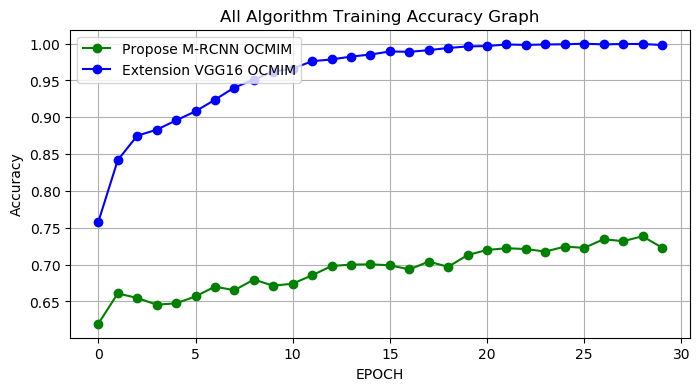

In [15]:
ocmim_acc, ocmim_loss = values("model/ocmim_history.pckl", "class_label_accuracy", "loss")
extension_acc, extension_loss = values("model/extension.pckl", "class_accuracy", "val_loss")
    
plt.figure(figsize=(8,4))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(ocmim_acc, 'ro-', color = 'green')
plt.plot(extension_acc, 'ro-', color = 'blue')
plt.legend(['Propose M-RCNN OCMIM','Extension VGG16 OCMIM'], loc='upper left')
plt.title('All Algorithm Training Accuracy Graph')
plt.show()

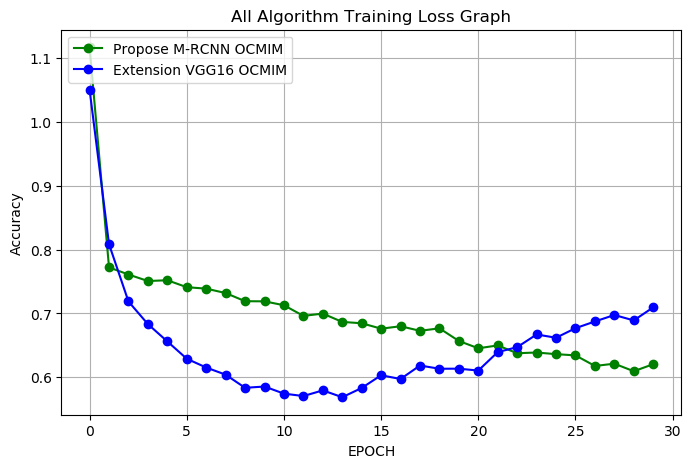

In [16]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(ocmim_loss, 'ro-', color = 'green')
plt.plot(extension_loss, 'ro-', color = 'blue')
plt.legend(['Propose M-RCNN OCMIM','Extension VGG16 OCMIM'], loc='upper left')
plt.title('All Algorithm Training Loss Graph')
plt.show()

In [17]:
#define attention model
attention_model = Model(ocmim_model.inputs, ocmim_model.layers[-10].output)#create attention model

In [18]:
#function to get attention map
def getAttentionMap(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = img.reshape(1,128,128,3)
    predict = model.predict(img1)
    pred = predict[0]
    attention = pred[:,:,7]
    return attention

In [19]:
#function to detect and classify object from given image path
def detectObject(image_path):
    img = cv2.imread(image_path)#read test image
    img = cv2.resize(img, (128, 128))#Resize image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = img.reshape(1,128,128,3)
    predict_value = ocmim_model.predict(img1)#perform prediction on test data using trained model
    predict = predict_value[0]#get bounding boxes
    predict = predict[0]
    predicted_label = predict_value[1][0] #get predicted label
    label = labels[np.argmax(predicted_label)]
    flag = True
    start = 0
    while flag:#now loop and plot all detected pedestrains
        if start < 20:
            x1 = predict[start] * 128
            start += 1
            y1 = predict[start] * 128
            start += 1
            x2 = predict[start] * 128
            start += 1
            y2 = predict[start] * 128
            start += 1
            if x1 > 0 and y1 > 0 and x2 > 0 and y2 > 20:
                cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 1, 1)
                cv2.putText(img, label, (int(x1), int(y1+40)),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)            
        else:
            flag = False
    attention_image = getAttentionMap(image_path)
    figure, axis = plt.subplots(nrows=1, ncols=2,figsize=(8,6))
    axis[0].set_title("Object Detected Image ("+label+")")
    axis[1].set_title("Attention Image")
    axis[0].imshow(img)
    axis[1].imshow(attention_image)
    figure.tight_layout()
    plt.axis('off')
    plt.show()

In [20]:
#call this function with test image path to detect and classify object
detectObject("testImages/1.jpg")

NameError: name 'model' is not defined

In [21]:
#call this function with test image path to detect and classify object
detectObject("testImages/8.jpg")

NameError: name 'model' is not defined

In [ ]:
#call this function with test image path to detect and classify object
detectObject("testImages/2.jpg")

In [ ]:
#call this function with test image path to detect and classify object
detectObject("testImages/10.jpg")

In [ ]:
#call this function with test image path to detect and classify object
detectObject("testImages/9.jpg")

In [ ]:
#call this function with test image path to detect and classify object
detectObject("testImages/10.jpg")

In [ ]:
#call this function with test image path to detect and classify object
detectObject("testImages/11.jpg")